In [2]:
from ipywidgets import FloatSlider, IntSlider, Dropdown, SelectionSlider, VBox, Button, Checkbox
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from ion_channel import IonChannel

def ion_channel_interactive(a, closed_0, closed_1, opened_0, opened_1, D, delta_t, records, random_force, takes_previous, seed, **force_params):
    """
    Generates an interactive widget for the ion channel model.
    """
    closed = (closed_0, closed_1)
    opened = (opened_0, opened_1)
    model = IonChannel(a, closed, opened, D, delta_t, records, takes_prev_vals=takes_previous, seed=seed, **force_params)
    model.ion_channel_model(random_force)
    return model


a_slider = FloatSlider(min=0.0, max=10.0, step=0.1, value=1, description='a')
closed_0_slider = IntSlider(min=-10, max=10, step=1, value=-1, description='Closed value')
closed_1_slider = FloatSlider(min=0.0, max=100.0, step=0.1, value=6.0, description='Closed avg time')
opened_0_slider = IntSlider(min=-10, max=10, step=1, value=1, description='Opened value')
opened_1_slider = FloatSlider(min=0.0, max=100.0, step=0.1, value=2.0, description='Opened avg time')
D_slider = FloatSlider(min=0.1, max=100.0, step=0.1, value=2.0, description='D')
delta_t_slider = SelectionSlider(
    options=[10**-i for i in range(1, 5)],
    value=0.01,
    description='Delta t',
)
records_slider = IntSlider(min=1000, max=100000, step=1000, value=50000, description='Records')

# model_force_dropdown=Dropdown(
#         options={'Square Force': model_force_square, 'Other Force': lambda x: x**2},
#         value=model_force_square,
#         description='Model Force',
# )

random_force_dropdown = Dropdown(
    options=['Gauss', 'Levy'],
    value='Gauss',
    description='Random Force',
)

takes_previous = Checkbox(value=True, description='Takes previous values')

seed_select = IntSlider(min=0, max=99999, value=12345, step=1, description='Seed')

force_params_box = VBox()

def update_force_params(*args):
    """
    Updates the force_params_box based on the selected random force.
    """
    force_type = random_force_dropdown.value
    if force_type.lower() == str.lower('Levy'):
        # Define widgets specific to 'Other Force'
        alpha = FloatSlider(min=0, max=2, step=0.01, value=1.9, description='alpha')
        beta_opened = FloatSlider(min=-1.0, max=0.0, step=0.01, value=-1.0, description='beta_opened')
        beta_closed = FloatSlider(min=0.0, max=1, step=0.01, value=1.0, description='beta_closed')
        loc = IntSlider(min=0, max=100, step=1, value=0, description='location')
        scale = FloatSlider(min=0, max=100, step=0.1, value=0.1, description='scale')
        force_params_box.children = [alpha, beta_closed, beta_opened, loc, scale]
    else:
        force_params_box.children = []

random_force_dropdown.observe(update_force_params, names='value')

display(
    seed_select,
    a_slider,
    closed_0_slider,
    closed_1_slider,
    opened_0_slider,
    opened_1_slider,
    D_slider,
    delta_t_slider,
    records_slider,
    force_params_box,
    takes_previous,
    random_force_dropdown
)

def on_button_click(b):
    """
    Callback for the 'Run Model' button.
    """
    force_params = {child.description: child.value for child in force_params_box.children}
    ion_channel_model = ion_channel_interactive(
        a_slider.value,
        closed_0_slider.value,
        closed_1_slider.value,
        opened_0_slider.value,
        opened_1_slider.value,
        D_slider.value,
        delta_t_slider.value,
        records_slider.value,
        random_force_dropdown.value,
        takes_previous.value,
        seed_select.value,
        **force_params
    )
    
    params_str = (
        f"a: {a_slider.value}, "
        f"closed_0: {closed_0_slider.value}, "
        f"closed_1: {closed_1_slider.value}, "
        f"opened_0: {opened_0_slider.value}, "
        f"opened_1: {opened_1_slider.value}, "
        f"D: {D_slider.value}, "
        f"delta_t: {delta_t_slider.value}, "
        f"records: {records_slider.value}, "
        f"random_force: {random_force_dropdown.label}, "
        f"force_params: {', '.join([f'{key}: {value}' for key, value in force_params.items()])} "
        f"seed: {seed_select.value}"
    )
    ion_channel_model.plot_time_series()
    ion_channel_model.plot_time_series_histogram()
    print(params_str)
    name = f"{random_force_dropdown.value}_D{D_slider.value}_a{a_slider.value}_{takes_previous.value}_{seed_select.value}"
    ion_channel_model.calculate_autocorrelation_acf(title=name)
    ion_channel_model.calculate_autocorrelation_dfa(title=name)

run_button = Button(description="Run Model")
run_button.on_click(on_button_click)
display(run_button)

IntSlider(value=12345, description='Seed', max=99999)

FloatSlider(value=1.0, description='a', max=10.0)

IntSlider(value=-1, description='Closed value', max=10, min=-10)

FloatSlider(value=6.0, description='Closed avg time')

IntSlider(value=1, description='Opened value', max=10, min=-10)

FloatSlider(value=2.0, description='Opened avg time')

FloatSlider(value=2.0, description='D', min=0.1)

SelectionSlider(description='Delta t', index=1, options=(0.1, 0.01, 0.001, 0.0001), value=0.01)

IntSlider(value=50000, description='Records', max=100000, min=1000, step=1000)

VBox()

Checkbox(value=True, description='Takes previous values')

Dropdown(description='Random Force', options=('Gauss', 'Levy'), value='Gauss')

Button(description='Run Model', style=ButtonStyle())

IntSlider(value=12345, description='Seed', max=99999)

FloatSlider(value=1.0, description='a', max=10.0)

IntSlider(value=-1, description='Closed value', max=10, min=-10)

FloatSlider(value=6.0, description='Closed avg time')

IntSlider(value=1, description='Opened value', max=10, min=-10)

FloatSlider(value=2.0, description='Opened avg time')

FloatSlider(value=2.0, description='D', min=0.1)

SelectionSlider(description='Delta t', index=1, options=(0.1, 0.01, 0.001, 0.0001), value=0.01)

IntSlider(value=50000, description='Records', max=100000, min=1000, step=1000)

VBox()

Checkbox(value=True, description='Takes previous values')

Dropdown(description='Random Force', options=('Gauss', 'Levy'), value='Gauss')

Button(description='Run Model', style=ButtonStyle())

Button Clicked
ion channel interactive called


<Figure size 640x480 with 0 Axes>

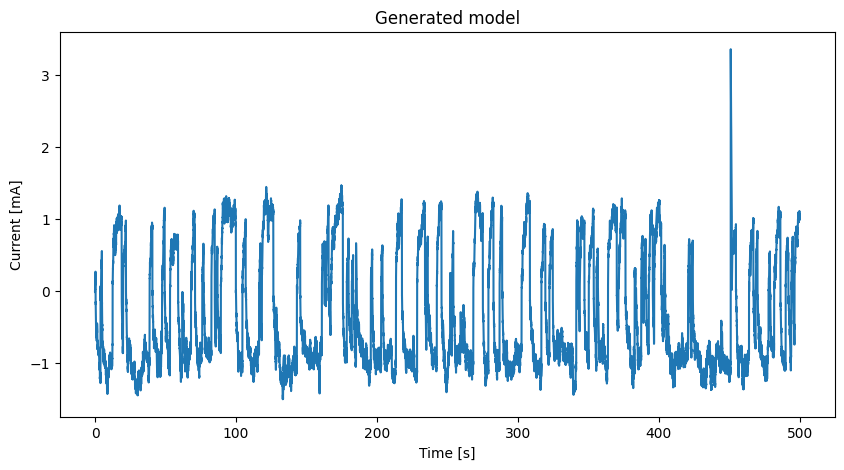

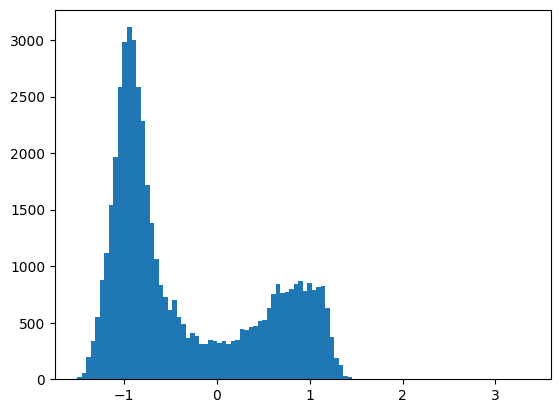

a: 1.0, closed_0: -1, closed_1: 6.0, opened_0: 1, opened_1: 2.0, D: 2.0, delta_t: 0.01, records: 50000, random_force: Levy, force_params: alpha: 1.9, beta_closed: 1.0, beta_opened: -1.0, location: 0, scale: 0.1 seed: 12345


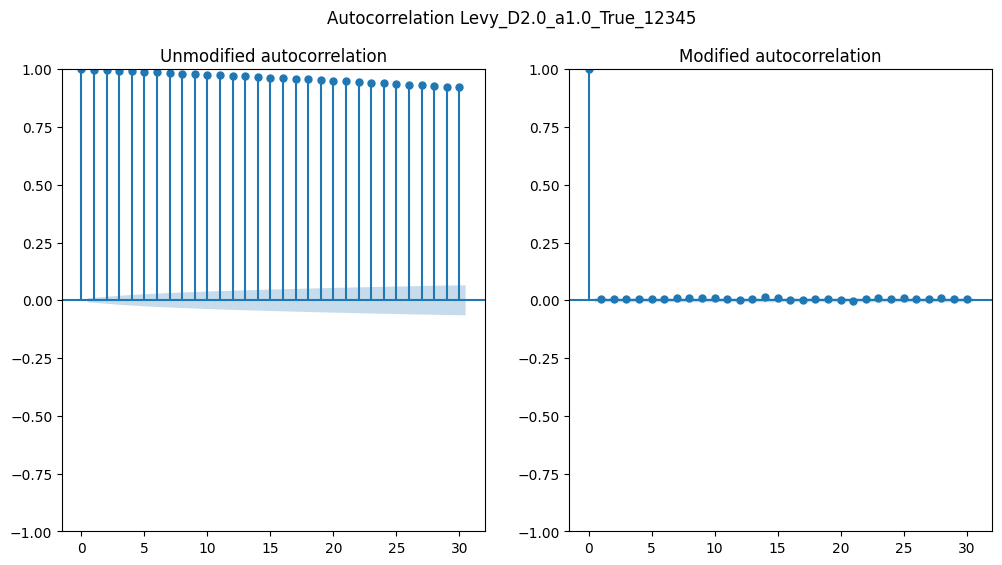

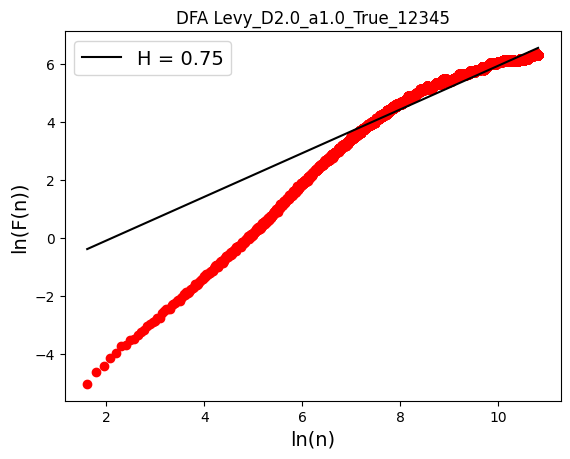

In [2]:
from ion_channel import InteractiveIonChannel

IIC = InteractiveIonChannel()
IIC.interact()

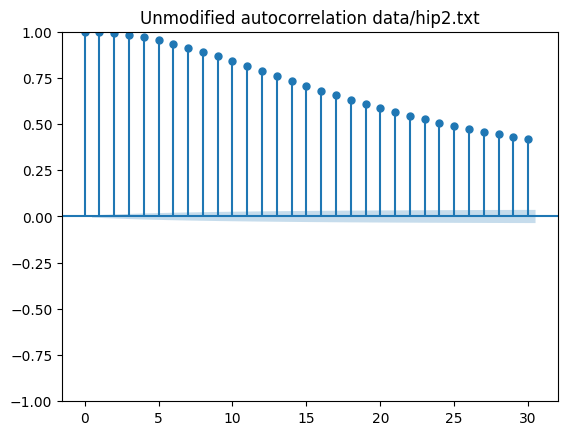

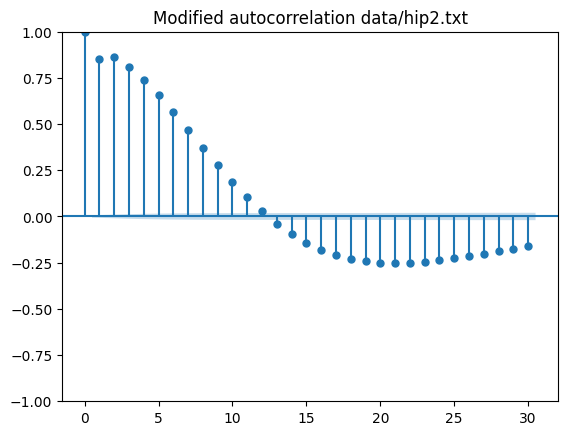

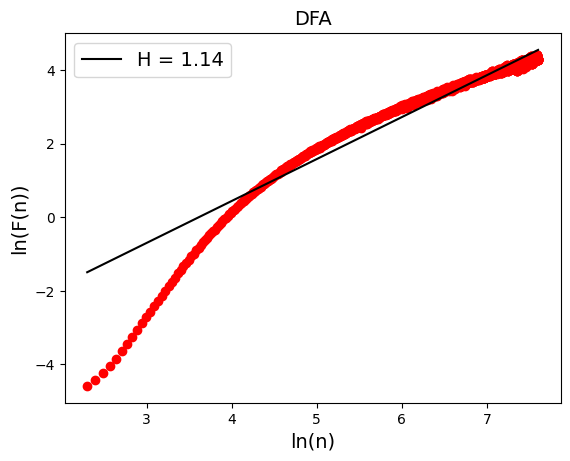

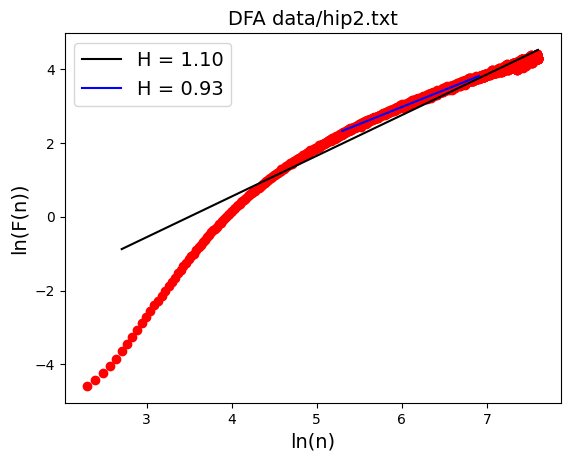

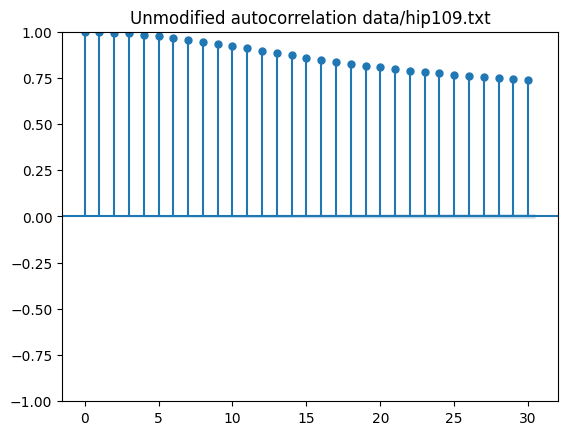

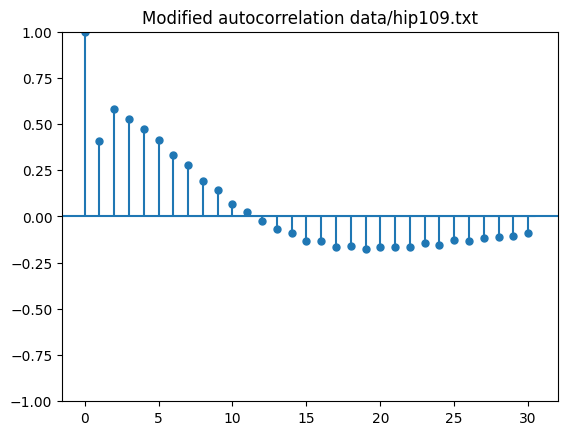

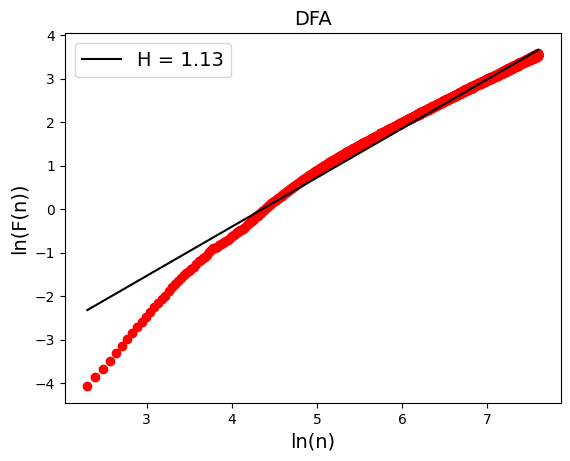

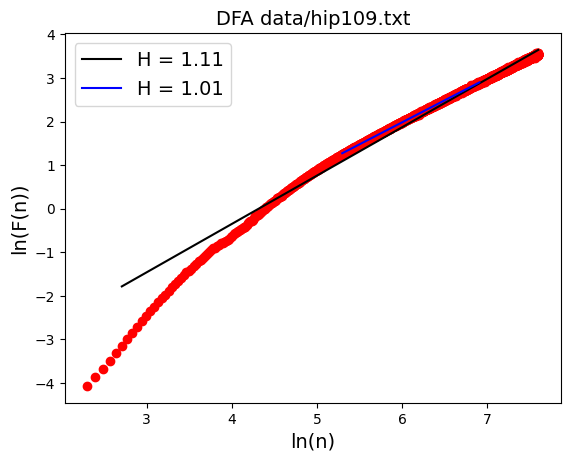

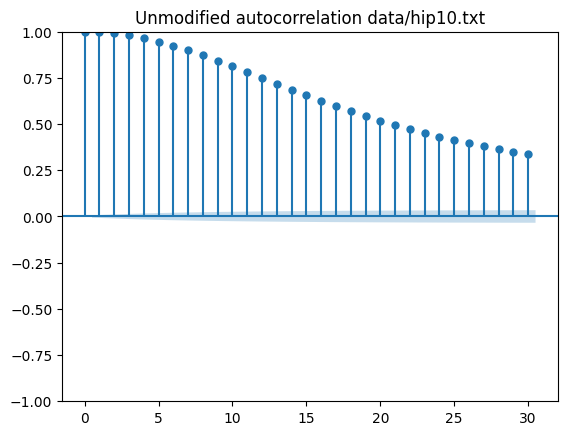

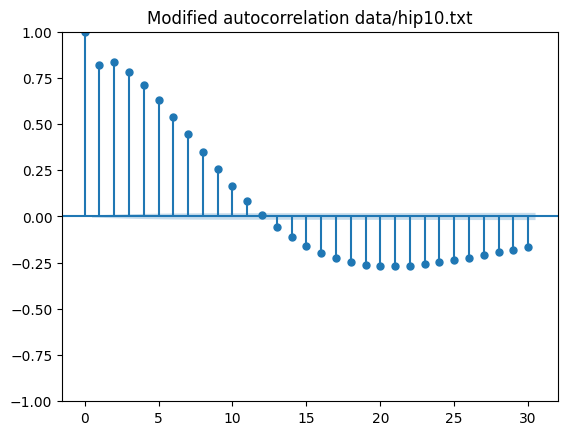

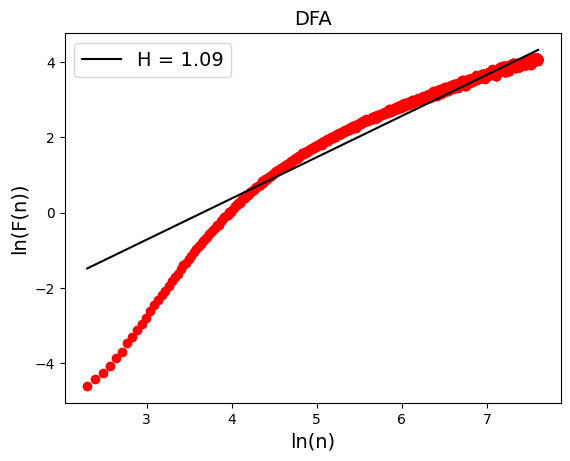

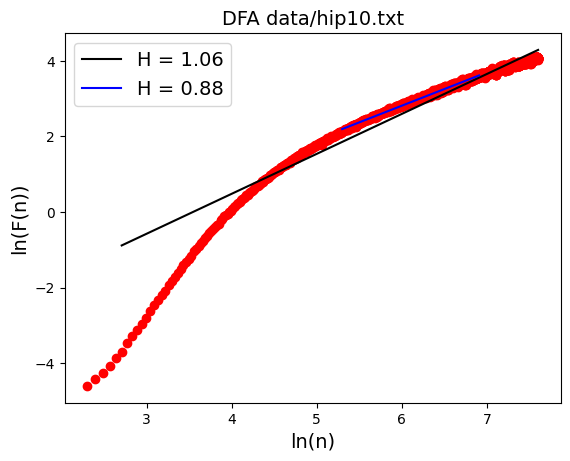

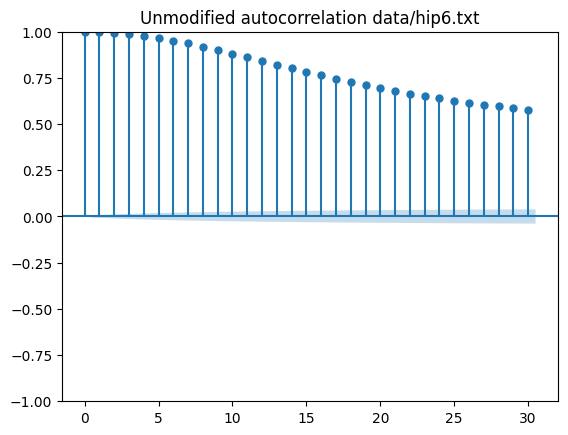

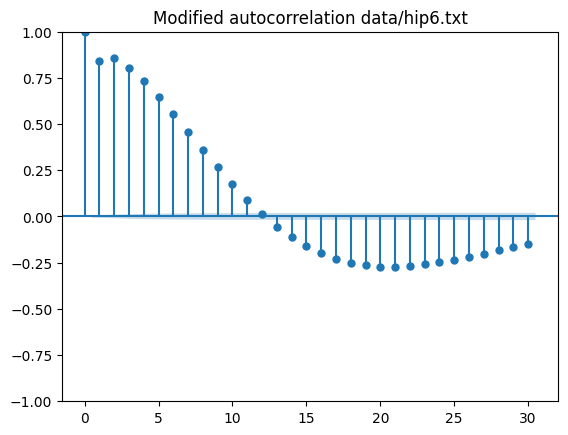

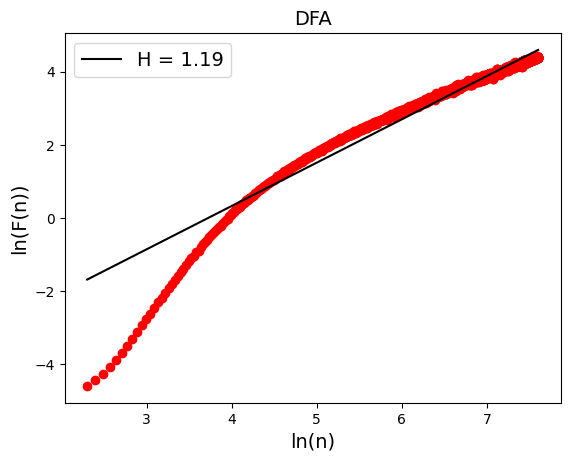

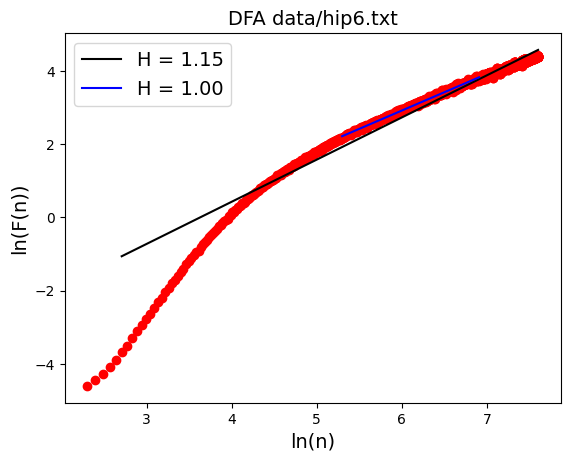

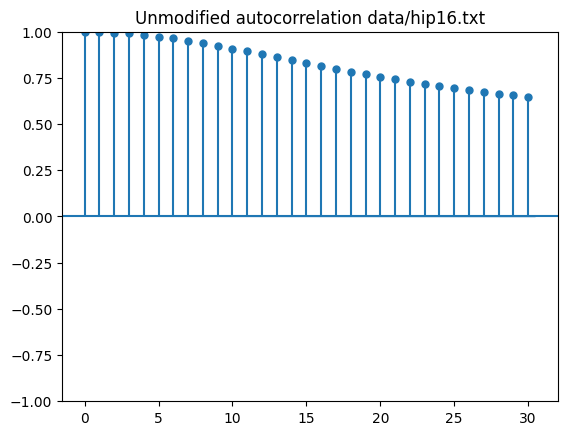

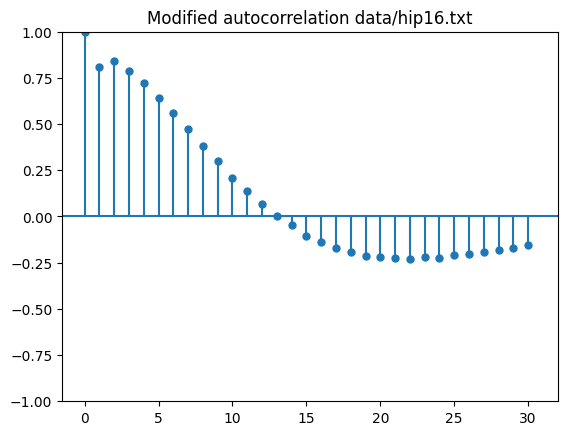

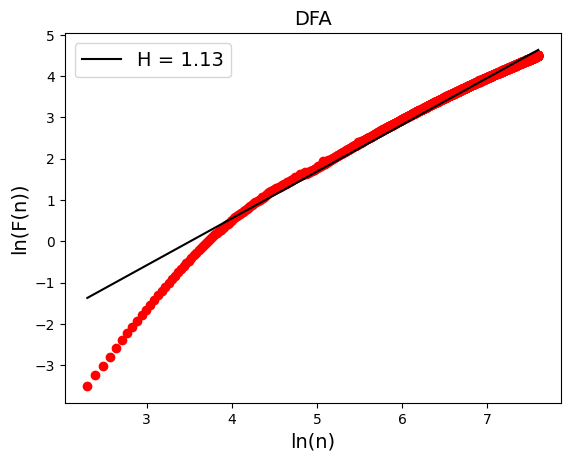

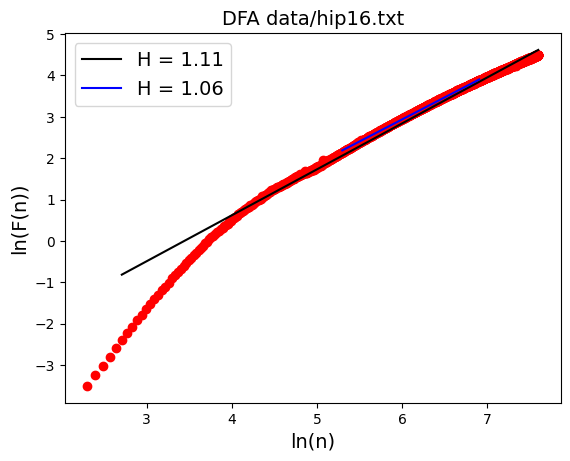

In [1]:
import os
import glob
import matplotlib.pyplot as plt
from monostable_model import calculate_autocorelation_dfa, calculate_autocorelation_acf
import numpy as np

# Find all hip files in the data directory
file_pattern = os.path.join("data", "hip*.txt")
files = glob.glob(file_pattern)
batch_size = 1
# Process each file
for file_path in files:
    cnt = 0
    sum = 0
    file_data = []
    
    with open(file_path) as data_file:
        for record in data_file:
            if cnt < batch_size:
                record = record.strip()
                sum += float(record)
                cnt += 1
            else:
                cnt = 0
                file_data.append(sum / batch_size)
                sum = 0
    
    # Calculate autocorrelation
    calculate_autocorelation_acf(file_data, title=file_path)
    calculate_autocorelation_dfa(file_data, title=file_path)